# Position Classification for FC Barcelona's Youth Players
### Team Sarria: Maëlys Boudier, Viktoriia Yuzkiv, Miguel Handt

**Course**: Computational Machine Learning taught by Anna Corretger

**Objective**: Predict a given player's position given a set of characteristics

## 0. Set-Up

### Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings 

# Libraries for Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# libraries for Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report

warnings.filterwarnings("ignore")

In [2]:
# Set global plots style
plt.style.use('ggplot')

In [3]:
# Set style for display format
pd.set_option('display.float_format', lambda x: '{:.1f}'.format(x) if x % 1 else '{:.0f}'.format(x))

In [4]:
# Set Preferences for Displaying Pandas Dataframes
pd.options.display.max_rows = 100
pd.options.display.max_columns = 30

### Load Data

In [5]:
# Define file path
file_path_train = os.getcwd()+'/train.csv'
file_path_test = os.getcwd()+'/test.csv'

# Load train and test data
train_raw = pd.read_csv(file_path_train)
test_raw = pd.read_csv(file_path_test)

In [6]:
print(f'The train dataset has {train_raw.shape[0]} rows and {train_raw.shape[1]} columns.') 

The train dataset has 6895 rows and 70 columns.


In [7]:
print(f'The test dataset has {test_raw.shape[0]} rows and {test_raw.shape[1]} columns.') 

The test dataset has 767 rows and 69 columns.


In [8]:
# Concatenate train and test data
df_raw = pd.concat([train_raw, test_raw], ignore_index=True)

# 1. Exploratory Data Analysis

### Check for Missing Values

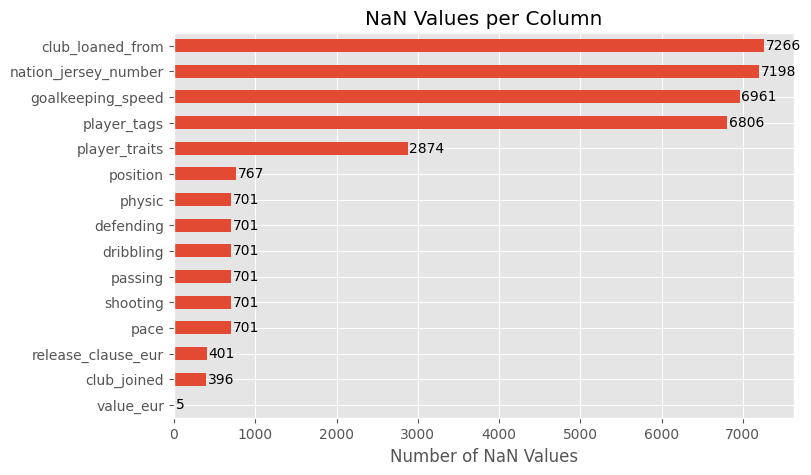

In [9]:
# Check for NaN values and filter columns with more than 0 NaN
na_counts = df_raw.isna().sum()
columns_with_nan = na_counts[na_counts > 0].index
df_missing = na_counts[columns_with_nan].sort_values(ascending=True)

ax = df_missing.plot(kind='barh', figsize=(8, 5))
plt.title('NaN Values per Column')
plt.xlabel('Number of NaN Values')

# Add numbers on the right side of each bar
for i, v in enumerate(df_missing):
    ax.text(v + 20, i, str(v), ha='left', va='center')

plt.show()

Columns that miss more than 80% of the data:
- club_loaned_from
- nation_jersey_number
- goalkeeping_speed
- player_tags

As the goalkeeping_speed most likely is related to the goal keeper characteristics only, it needs more investigation to check if it is populated only for goal keepers or if it also has missing data.

Columns club_loaned_from, nation_jersey_number, player_tags will be dropped in the Data Preparation part due to the high missing values number.

In [10]:
# Checking if goalkeeping_speed is imputed only for position == GK (in the train data only as the test data doesn't have the position column)

res = train_raw[train_raw['position'] == 'GK']['goalkeeping_speed'].notnull().all()
print(f'All values for GK are imputed: {res}')

res1 = train_raw[train_raw['position'] != 'GK']['goalkeeping_speed'].isnull().all()
print(f'No values of goalkeeping_speed for all the other positons are imputed: {res1}')

All values for GK are imputed: True
No values of goalkeeping_speed for all the other positons are imputed: True


Therefore, we see that goalkeeping_speed is imputed only for the position of GK, for all the other positions it's NaN.

In [11]:
na_counts_GK = df_raw[df_raw['position'] == 'GK'].isna().sum().sort_values(ascending=True)
print('Missing values for the GK position: \n')
print(na_counts_GK[na_counts_GK > 0])

Missing values for the GK position: 

release_clause_eur       33
club_joined              33
player_traits           251
nation_jersey_number    571
club_loaned_from        598
pace                    631
shooting                631
passing                 631
dribbling               631
defending               631
player_tags             631
physic                  631
dtype: int64


Also we see that for the GK position such columns as pace, shooting, passing, dribbling, defending, player_tags, physic are completely missing, so we assume that those are not relevant for GK.

### Numerical Variables Exploration

In [12]:
# Summary statistics for numerical columns
df_raw[['overall', 'potential', 'wage_eur', 'value_eur',
        'release_clause_eur', 'height_cm', 'weight_kg', 'pace', 'club_contract_valid_until']].describe()

,overall,potential,wage_eur,value_eur,release_clause_eur,height_cm,weight_kg,pace,club_contract_valid_until
count,7662,7662,7662,7657,7261,7662,7662,6961,7662
mean,68.8,72.0,12030.3,4331452.9,8187938.3,181.5,75.6,68.6,2022.8
std,6.0,6.1,24385.9,10450193.9,20446557.0,6.9,7.0,11.7,1.2
min,48,53,500,25000,39000,156,53,28,2021
25%,65,68,2000,725000,1100000,177,70,62,2022
50%,68,72,4000,1400000,2300000,182,75,70,2023
75%,72,76,12000,3000000,5400000,186,80,77,2024
max,93,95,350000,194000000,373500000,203,103,97,2031


Columns value_eur, wage_eur, and release_clause_eur have high standard deviations, suggesting the presence of extreme values (potential outliers). It will be explored more in the further analysis.

Columns height_cm and weight_kg have moderate standard deviations, indicating some variability in player physical attributes. The relationships between player posisions and the phisical attributes will be studied later as well.

Column pace has a very low minimum value of 28 as opposed to other values between Q1=62, Median = 70, Q3=77, Max = 97

Most of the values in the column club_contract_valid_until are in the 2021-2024 range, but the maximum value is 2031, so this column will be checked for ouliers, too.

All the other columns have relatively law standard deviations and are not a cause for concern.

Let's check the distributions of wage_eur, value_eur, and release_clause_eur variables:

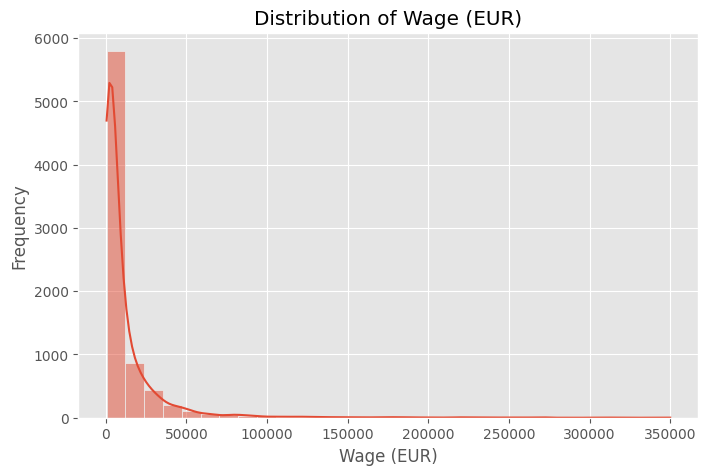

In [13]:
# Visualize the distribution of the wage_eur variable

plt.figure(figsize=(8, 5))
sns.histplot(df_raw['wage_eur'], bins=30, kde=True)
plt.title('Distribution of Wage (EUR)')
plt.xlabel('Wage (EUR)')
plt.ylabel('Frequency')
plt.show()

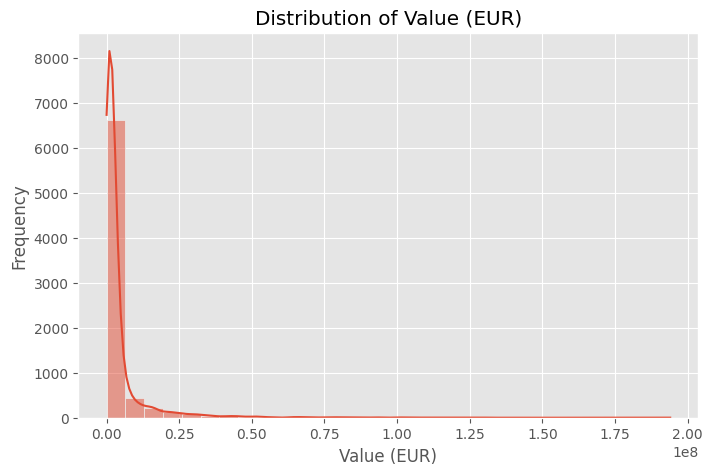

In [14]:
# Visualize the distribution of the value_eur variable

plt.figure(figsize=(8, 5))
sns.histplot(df_raw['value_eur'], bins=30, kde=True)
plt.title('Distribution of Value (EUR)')
plt.xlabel('Value (EUR)')
plt.ylabel('Frequency')
plt.show()

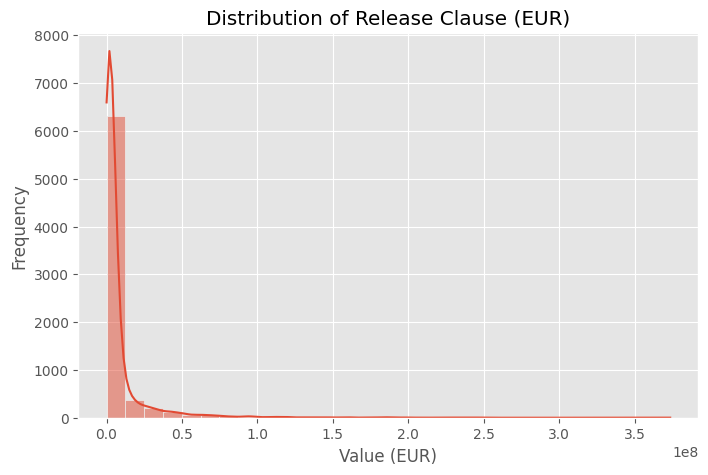

In [15]:
# Visualize the distribution of the value_eur variable

plt.figure(figsize=(8, 5))
sns.histplot(df_raw['release_clause_eur'], bins=30, kde=True)
plt.title('Distribution of Release Clause (EUR)')
plt.xlabel('Value (EUR)')
plt.ylabel('Frequency')
plt.show()

As we can see in the boxplots above, all three variables of interest are highly right skewed and might have outliers. These will be studied more and removed if needed in the data preparation part. Also, due to the big variance of values, it is important to standardise the values.

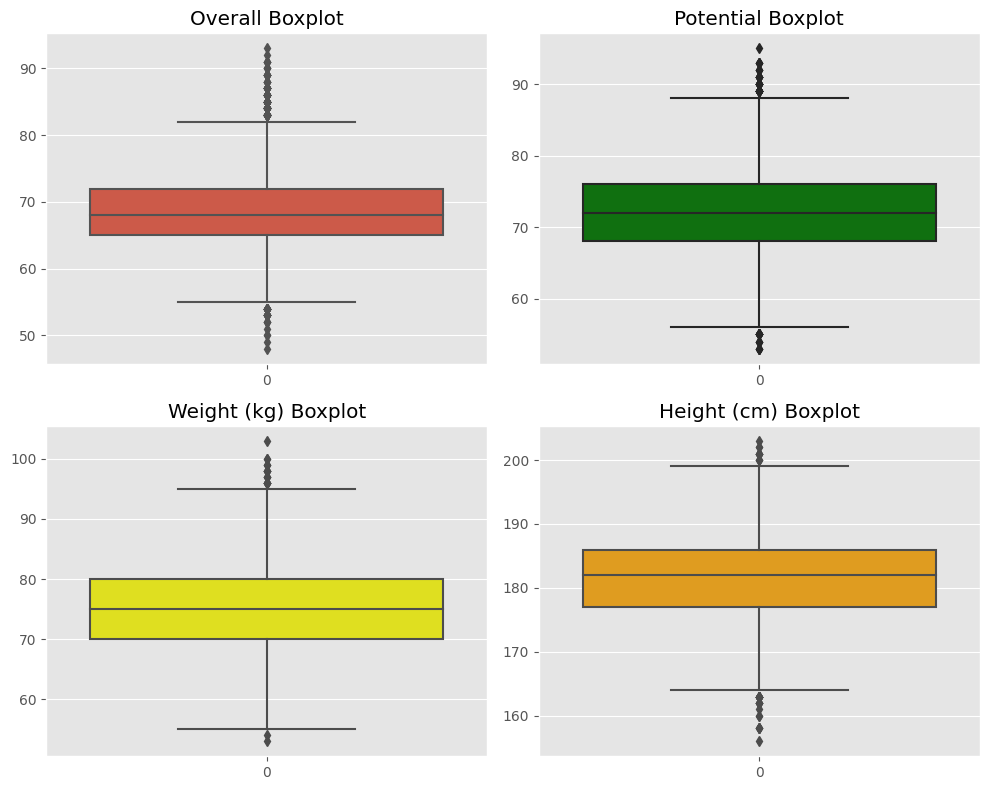

In [16]:
# Check other main numerical columns

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.boxplot(df_raw['overall'], ax = axes[0,0])
axes[0,0].set_title('Overall Boxplot')

sns.boxplot(df_raw['potential'], ax = axes[0,1], color='green')
axes[0,1].set_title('Potential Boxplot')

sns.boxplot(df_raw['weight_kg'], ax = axes[1,0], color = 'yellow')
axes[1,0].set_title('Weight (kg) Boxplot')

sns.boxplot(df_raw['height_cm'], ax = axes[1,1], color='orange')
axes[1,1].set_title('Height (cm) Boxplot')

plt.tight_layout()
plt.show()

There might be some outliers in the overall, potential, weight_kg, height_cm columns, too. We will check later if it's needed to remove them from the data.


Let's take a look at correlations between the numerical variables.

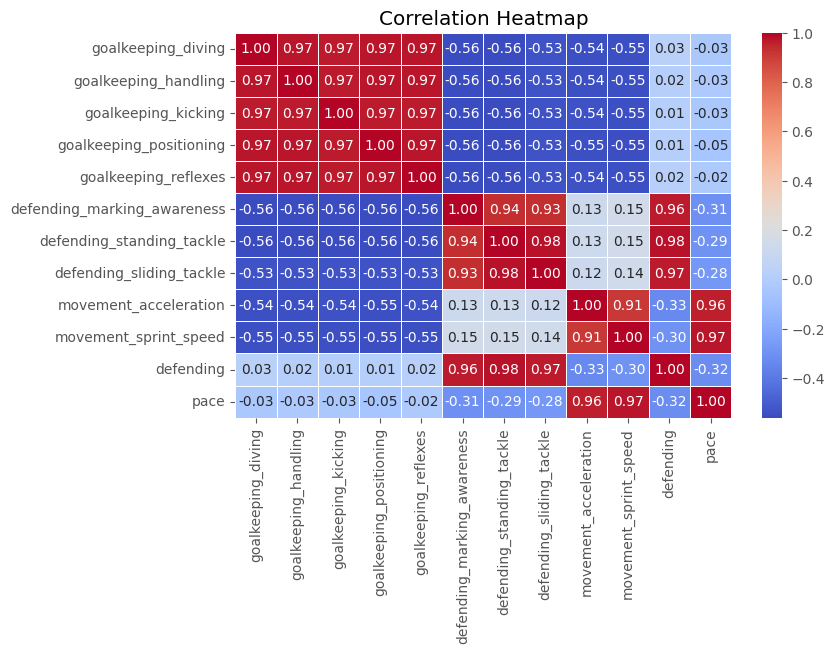

In [17]:
# Correlation heatmap 1

cols = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
        'goalkeeping_reflexes', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
        'movement_acceleration', 'movement_sprint_speed', 'defending', 'pace']

correlation_matrix = df_raw[cols].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

As we can see in the table above, all goalkeeping variables are highly positively correlated with each other.

Moreover, it is important to mention that columns 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'defending' are highly positively correlated between each other. Some of them might need to be dropped to avoid multicolinearity. This will be taken into account while feature selection for the model.

The same we can see for 'movement_acceleration', 'movement_sprint_speed', and 'pace'.

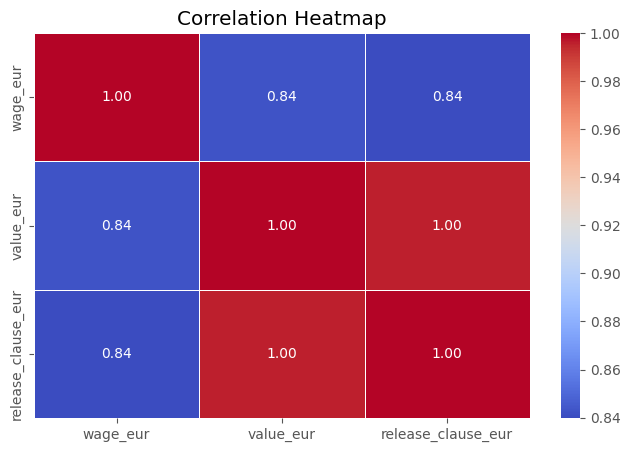

In [18]:
# Correlation heatmap 2

cols = ['wage_eur', 'value_eur', 'release_clause_eur']

correlation_matrix = df_raw[cols].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Release_clause_eur is perfectly correlated to value_err. Wage_eur is also highly positively correlated with two other variables. To avoid multicollinearity, we will proceed with only one of them - value_eur.

### Categorical Variables Exploration

In [19]:
# Summary table for categorical variables
def categorical_summary(df):
    # Initialize an empty DataFrame to store the results
    cat_summary_df = pd.DataFrame(columns=['Variable', 'Data Type', 'Unique Values', 'Missing Values (%)', 'Top Values'])
    
    # Iterate over all columns and fill the summary DataFrame for categorical columns
    for column in df.columns:
        if df[column].dtype == 'O':
            unique_values = df[column].nunique()
            missing_percentage = (df[column].isnull().mean()) * 100
            top_values = df[column].value_counts().head().index.tolist()

            # Add a new row to the summary DataFrame
            cat_summary_df.loc[len(cat_summary_df.index)] = [column, df[column].dtype, unique_values, missing_percentage, top_values]
    
    return cat_summary_df

summary_df = categorical_summary(df_raw)
display(summary_df)

,Variable,Data Type,Unique Values,Missing Values (%),Top Values
0,short_name,object,7418,0,"[J. Rodríguez, J. Brown, Danilo, L. Rodríguez,..."
1,birthday_date,object,4214,0,"[1992-02-29, 1996-02-29, 2000-02-29, 1988-02-2..."
2,club_name,object,701,0,"[Club Atlético de San Luis, Atlético Nacional,..."
3,league_name,object,55,0,"[USA Major League Soccer, Argentina Primera Di..."
4,club_loaned_from,object,207,94.8,"[Racing Club, Watford, Manchester United, Wolv..."
5,club_joined,object,1331,5.2,"[2021-07-01, 2019-07-01, 2018-07-01, 2017-07-0..."
6,nationality_name,object,144,0,"[England, Brazil, Germany, Spain, Argentina]"
7,preferred_foot,object,2,0,"[Right, Left]"
8,work_rate,object,9,0,"[Medium/Medium, High/Medium, Medium/High, High..."
9,body_type,object,10,0,"[Normal (170-185), Normal (185+), Lean (170-18..."


As the position of the player does not depend on the birthday date, it is possible that there is relationship between the age of the player (or year born) and the position.

In [20]:
# Convert 'birthday_date' to datetime format
df_raw['birthday_date'] = pd.to_datetime(df_raw['birthday_date'])

# Extract the year and create a new column 'year_born'
df_raw['year_born'] = df_raw['birthday_date'].dt.year

The variable body_type might be the combination of height_cm and weight_cm. Let's take a look at the chart to see if this hypothesis is true. If yes, we can remove the body_type column from our dataset.

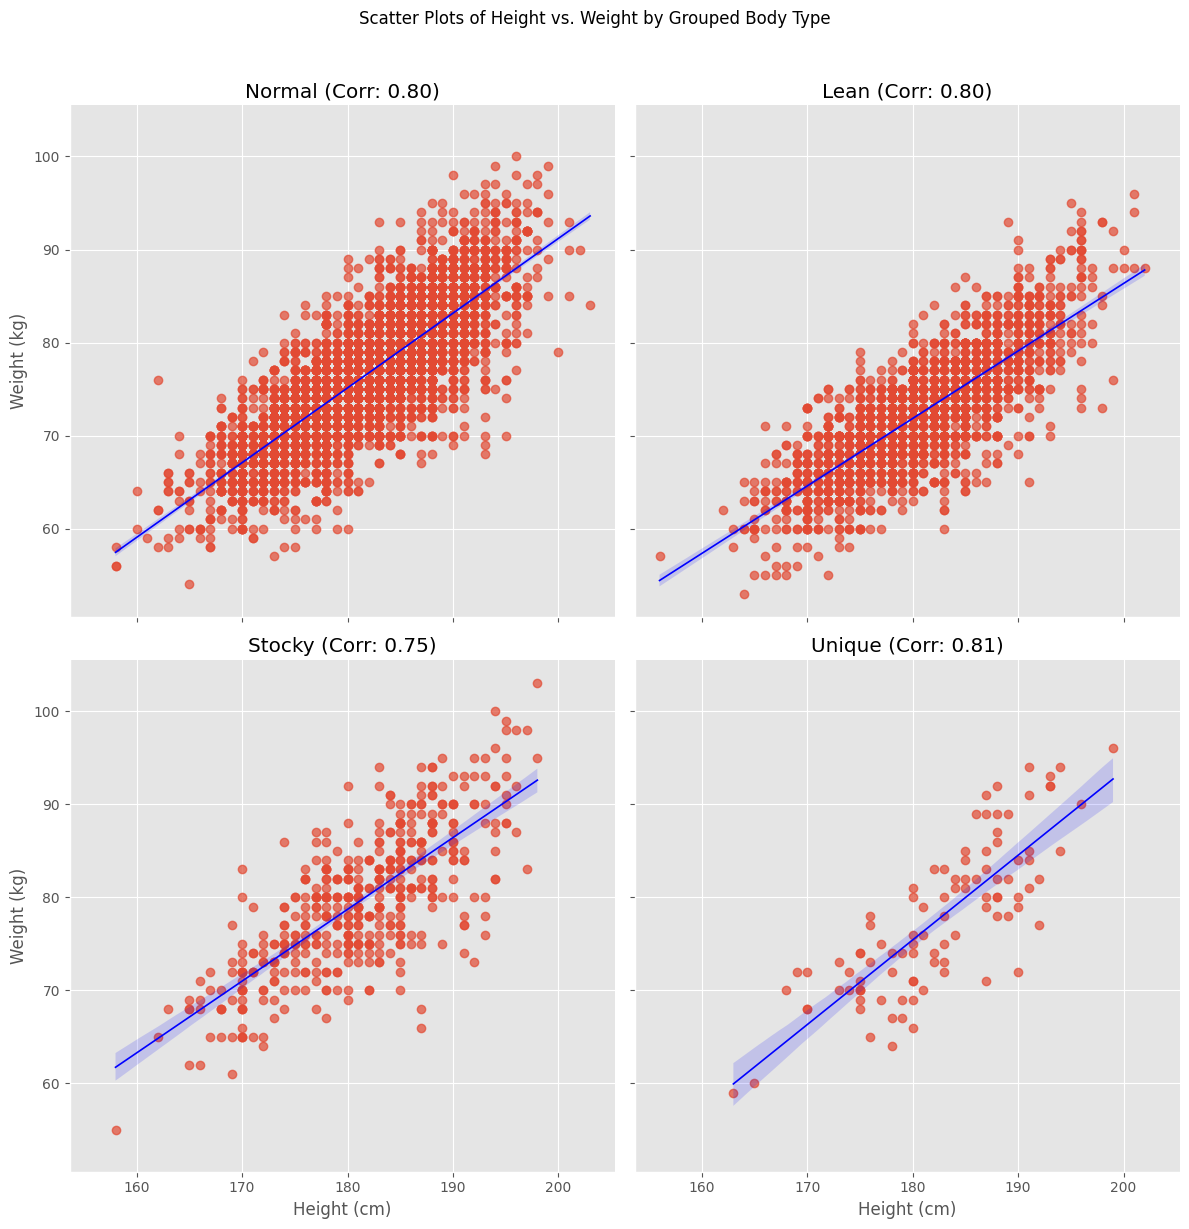

In [21]:
# Create a new column 'body_type_grouped' based on the existing 'body_type' values
df_raw['body_type_grouped'] = df_raw['body_type'].apply(lambda x: 'Normal' if 'Normal' in x else ('Lean' if 'Lean' in x else ('Stocky' if 'Stocky' in x else 'Unique')))

# Create a FacetGrid with separate subplots for each grouped body type
g = sns.FacetGrid(df_raw, col='body_type_grouped', col_wrap=2, height=6)
g.map(sns.regplot, 'height_cm', 'weight_kg', scatter_kws={'alpha': 0.7}, line_kws={'color': 'blue', 'linewidth': 1.2})  # Use the alpha parameter to control point transparency
g.set_axis_labels('Height (cm)', 'Weight (kg)')

# Add a title with correlation score to each subplot
for ax in g.axes.flat:
    body_type = ax.get_title().split('=')[-1].strip()
    subset = df_raw[df_raw['body_type_grouped'] == body_type]
    correlation = subset[['height_cm', 'weight_kg']].corr().iloc[0, 1]
    ax.set_title(f'{body_type} (Corr: {correlation:.2f})')

g.fig.suptitle('Scatter Plots of Height vs. Weight by Grouped Body Type', y=1.02)
plt.tight_layout()
plt.show()

For all body types we see that there is a strong linear relationship between weight_cm and height_cm.

#### Explore the 'Position' Column

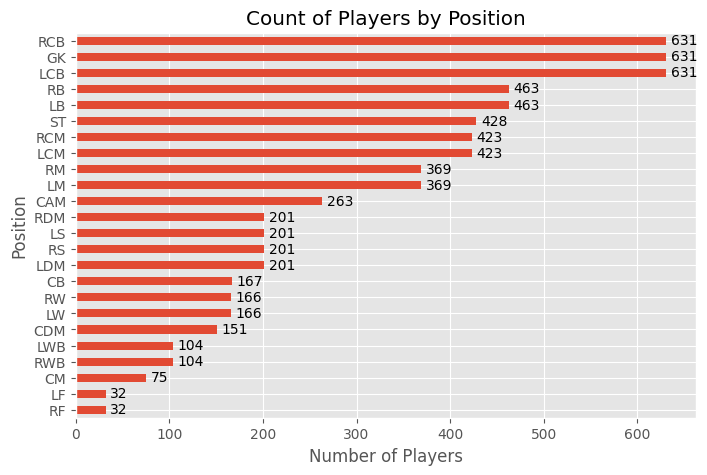

In [22]:
# Number of players by position
position_count = df_raw['position'].value_counts().sort_values(ascending=True)

ax = position_count.plot(kind='barh', figsize=(8, 5))
plt.title('Count of Players by Position')
plt.xlabel('Number of Players')
plt.ylabel('Position')

# Add numbers on the right side of each bar
for i, v in enumerate(position_count):
    ax.text(v + 5, i, str(v), ha='left', va='center')

plt.show()

As we can see in the chart above, the number of players by position is very imbalanced across different positions and should be taken into account while working in the model.

Let's check if the main player characteristics differ between positions. 

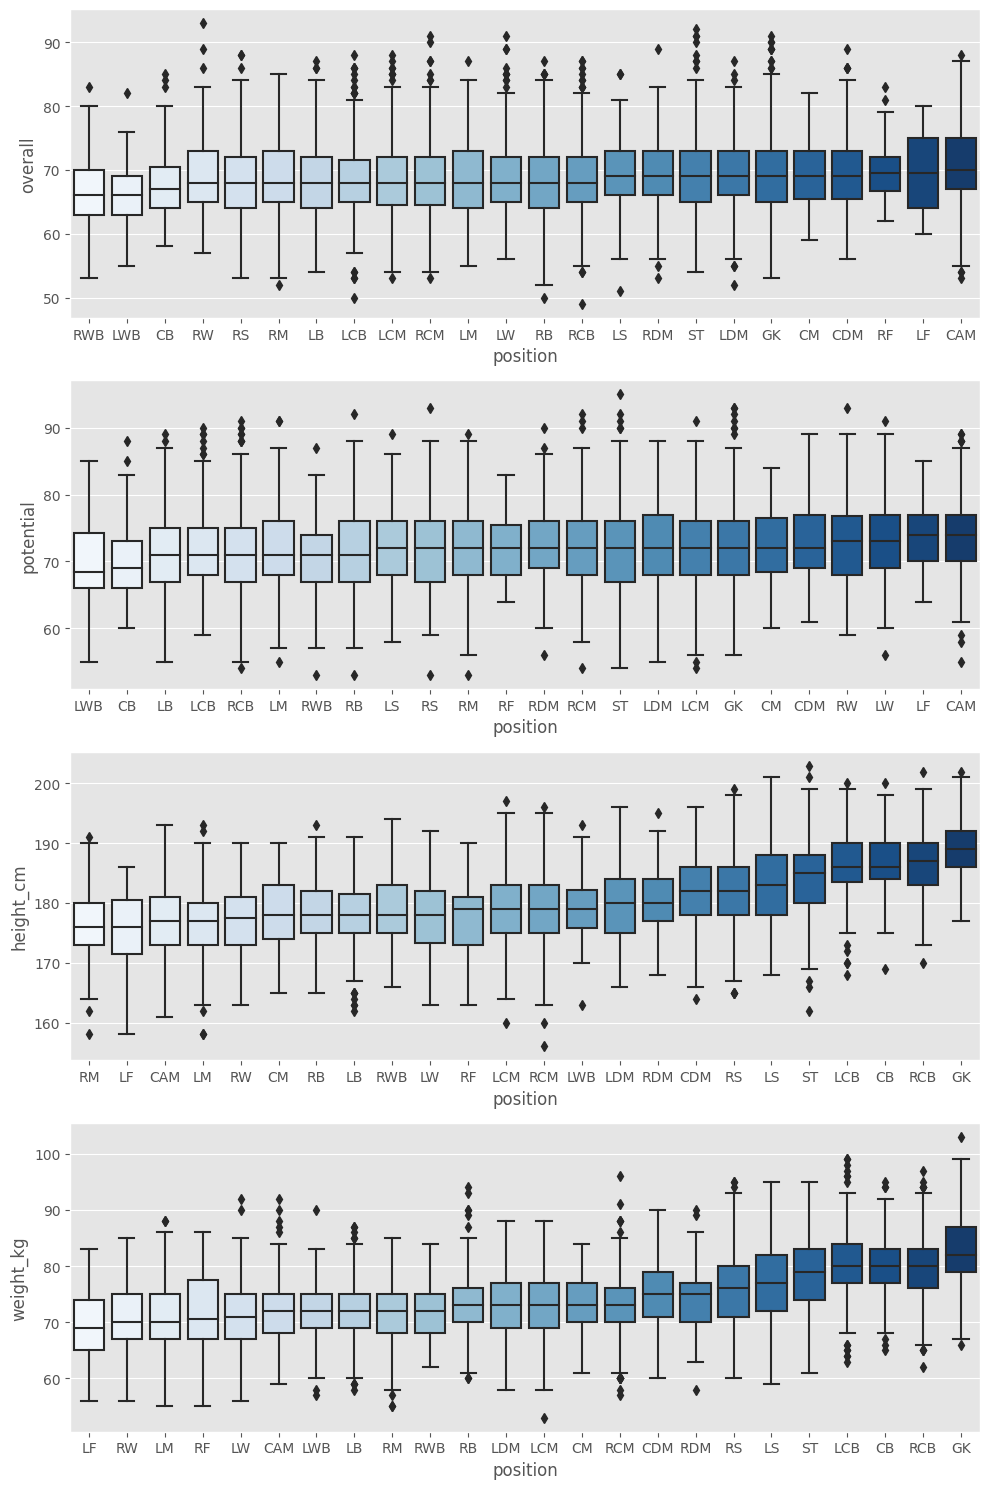

In [23]:
# Calculate the median overall for each position
median_overall = df_raw.groupby('position')['overall'].median().sort_values(ascending=True)

# Calculate the meadian potential for each position
median_potential = df_raw.groupby('position')['potential'].median().sort_values(ascending=True)

# Calculate the meadian height for each position
median_heights = df_raw.groupby('position')['height_cm'].median().sort_values(ascending=True)

# Calculate the meadian weight for each position
median_weights = df_raw.groupby('position')['weight_kg'].median().sort_values(ascending=True)

# Create a subplot with two axes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# Plot the boxplot for overall on the first axis
sns.boxplot(ax=axes[0], x='position', y='overall', data=df_raw, palette='Blues', order=median_overall.index)

# Plot the boxplot for potential on the second axis
sns.boxplot(ax=axes[1], x='position', y='potential', data=df_raw, palette='Blues', order=median_potential.index)

# Plot the boxplot for height on the third axis
sns.boxplot(ax=axes[2], x='position', y='height_cm', data=df_raw, palette='Blues', order=median_heights.index)

# Plot the boxplot for weight on the fourth axis
sns.boxplot(ax=axes[3], x='position', y='weight_kg', data=df_raw, palette='Blues', order=median_weights.index)

# Adjust layout
plt.tight_layout()
plt.show()

While for overall and potential columns the difference is quite small among different positions, players height and weight are very different for some positions.

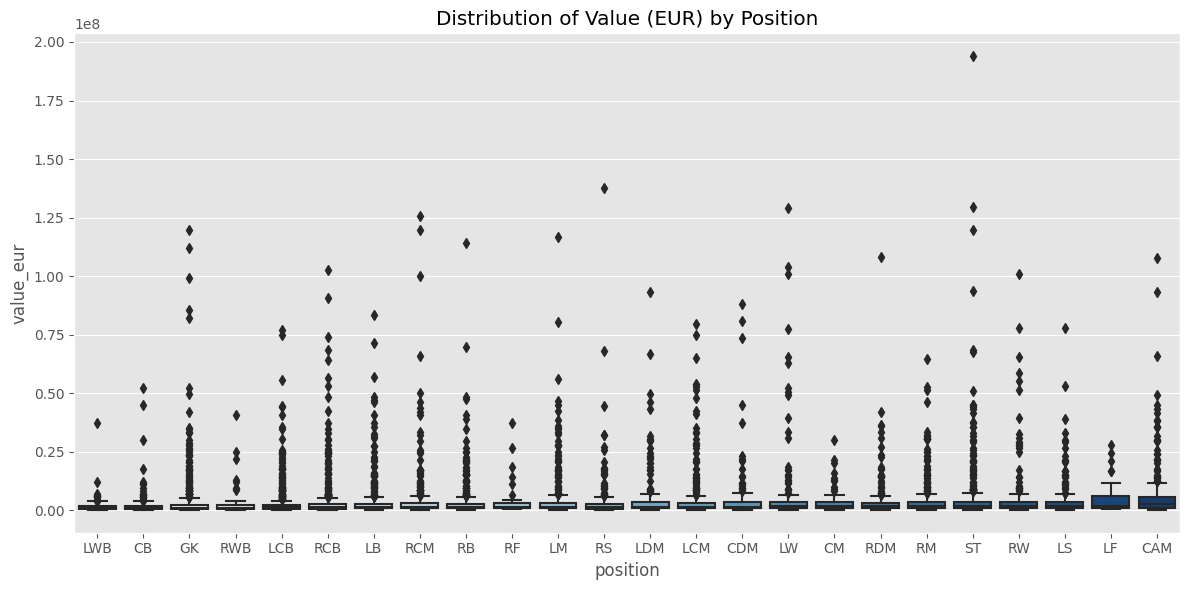

In [24]:
# Calculate the median wage for each position
median_wage_eur = df_raw.groupby('position')['value_eur'].median().sort_values(ascending=True)

## Create a boxplot to visualize the distribution of 'wage_eur' by 'position'
plt.figure(figsize=(12, 6))
sns.boxplot(x='position', y='value_eur', data=df_raw, palette='Blues', order=median_wage_eur.index)
plt.title('Distribution of Value (EUR) by Position')
plt.tight_layout()
plt.show()

It's difficult to compare wage_eur median values based on the chart above, as the values range is very big. Let's check the table of meadian wage_eur by position:

In [25]:
df_raw.groupby('position')['value_eur'].median().reset_index().sort_values(by='value_eur', ascending=False)

,position,value_eur
0,CAM,2400000
9,LF,1950000
21,RW,1700000
11,LS,1700000
19,RM,1600000
17,RDM,1600000
12,LW,1600000
23,ST,1600000
3,CM,1600000
8,LDM,1500000


There is a difference in the medium value_eur across different positions.

There are 2 positions with the highest median values:
- CAM: 2400000 EUR
- LF: 1950000.0 EUR

Positions with the lowest median values are LWB, CB, RWB.

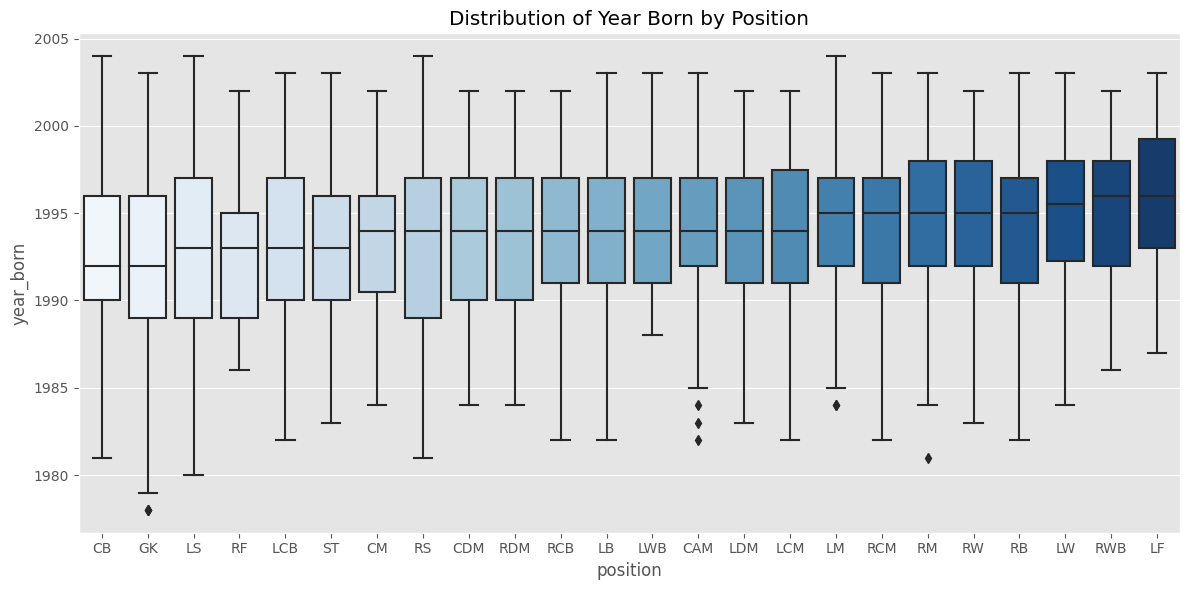

In [26]:
# Create a boxplot of year_born by position
median_year = df_raw.groupby('position')['year_born'].median().sort_values(ascending=True)

plt.figure(figsize=(12, 6))
sns.boxplot(x='position', y='year_born', data=df_raw, palette='Blues', order=median_year.index)

plt.title('Distribution of Year Born by Position')
plt.tight_layout()
plt.show()

It is shown in the chart above that CB and GK are usually the youngest players, while LF, RWB, and LW are the oldest ones.

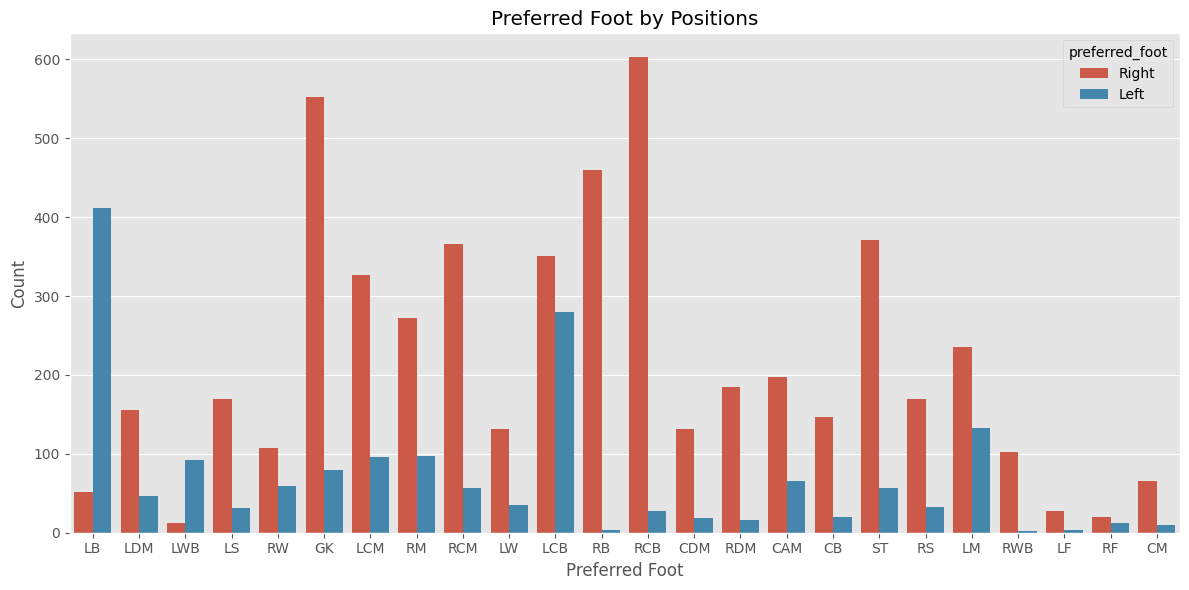

In [27]:
# Create a count plot to visualize the distribution of preferred_foot across positions
plt.figure(figsize=(12, 6))
sns.countplot(x='position', hue='preferred_foot', data=df_raw)
plt.title('Preferred Foot by Positions')
plt.xlabel('Preferred Foot')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Only players at LB and LCB have high share of Left as a preferred foot. Taking this into account may help identify positions more precise.

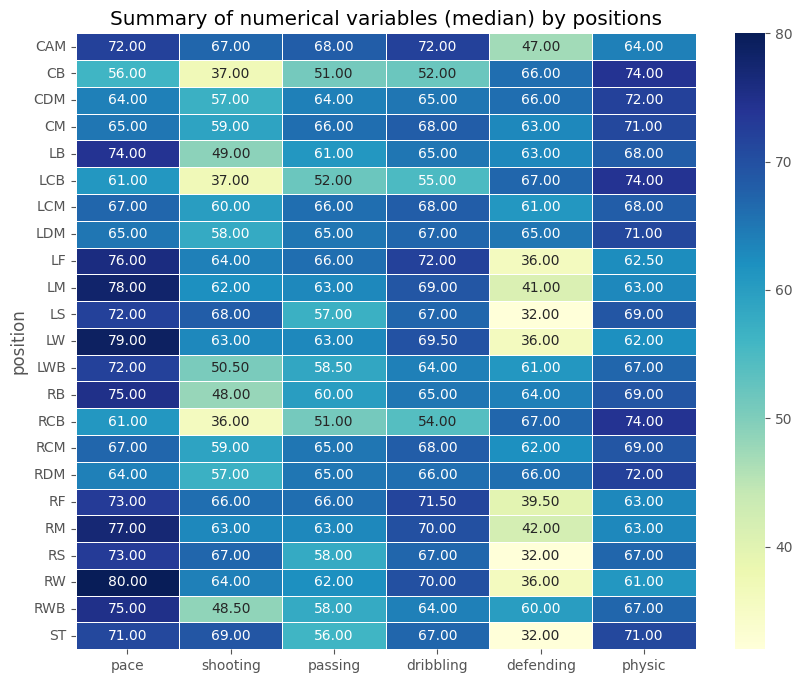

In [28]:
# Add table for main numerical variables summary by position
num_columns = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

# Exclude 'GK' position from the data as it's not relevant here
filtered_data = df_raw[df_raw['position'] != 'GK']

grouped_data = filtered_data[num_columns + ['position']].groupby(by='position').agg('median').reset_index()


# Set the position column as the index for better visualization
grouped_data.set_index('position', inplace=True)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(grouped_data, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title("Summary of numerical variables (median) by positions")
plt.show()


Taking a look at the table with mean pace, shooting, passing, dribbling, defending, physic variables, we can conclude that the data proves our hypotheses that:
- Strikers have very low defending values and higher shooting values, suggesting good shooting abilities.
- Defenders generally have high values, indicating strong defensive capabilities.
- Wingers usually have very high pace values indicating speed on the wings.
- Midfielders have a bit higher passing values than the others, indicating good playmaking skills.

# 2. Data Preprocessing & Quality Assurance

Recommendations based on data exploration:
- drop columns with more than 80% of missing values
- Predict GK separately since GK variables (pace, shooting, passing, dribbling, defending, player_tags) only have values for GK
- Treat outliers in overall, potential, weight_kg, height_cm, wage_eur and value_eur
- Remove the body_type column as it's basically the combination of height_cm and weight_cm
- Transform birthday_date to year -> created the column "year_born"

Idea for imputation - it might make sence to do it for each position separately.


### Drop the columns with more than 80% of missing values

In [29]:
# Drop columns club_loaned_from, nation_jersey_number, player_tags
df_raw = df_raw.drop(columns=['club_loaned_from', 'nation_jersey_number', 'player_tags'])

### Drop the columns wage_eur,  release_clause_eur due to multicollinearity

In [30]:
# Drop columns wage_eur, release_clause_eur
df_raw = df_raw.drop(columns=['wage_eur', 'release_clause_eur'])

### Treat outliers with Winsorization

Winsorization is the transformation of values by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers, we use the 1st and 99th percentile to perform this transformation. 

* **height_cm, weight_kg**: have some outliers reflected in the box plots (in the EDA section)
* **overall, potential**: have some outliers reflected in the box plots (in the EDA section)
* **club_contract_valid_until**: most values are in the 2021-2024 range but the maximum value is 2031
* **value_eur**: it has a very big range of values and is worse checking for outliers
* **pace**: a very low minimum value of 28 as opposed to other values ('describe table' in the EDA section)


In [31]:
outliers_features = ['height_cm', 'weight_kg', 'overall', 'potential', 'club_contract_valid_until', 'value_eur', 'pace']

def winsorize_col(df_raw, col):
    df_raw = df_raw.copy()
    # Calculate the 1st and 99th percentiles
    first_percentile = df_raw[col].quantile(0.01)
    ninety_ninth_percentile = df_raw[col].quantile(0.99)

    # Number of outliers having viewd the box plot. 
    count = len(df_raw[df_raw[col] < first_percentile]) + len(df_raw[df_raw[col] > ninety_ninth_percentile])
    print(f'outliers in {col}:', count)

    # Windsorize the 'num_rooms' column
    df_raw[col] = df_raw[col].apply(lambda x: first_percentile if x < first_percentile else (ninety_ninth_percentile if x > ninety_ninth_percentile else x))

    # Number of outliers remaining 
    count = len(df_raw[df_raw[col] < first_percentile]) + len(df_raw[df_raw[col] > ninety_ninth_percentile])
    print('outliers after winsorizing:', count)

    return df_raw

for feature in outliers_features: 
    df_raw = winsorize_col(df_raw, feature)
    print()

outliers in height_cm: 128
outliers after winsorizing: 0

outliers in weight_kg: 101
outliers after winsorizing: 0

outliers in overall: 130
outliers after winsorizing: 0

outliers in potential: 152
outliers after winsorizing: 0

outliers in club_contract_valid_until: 10
outliers after winsorizing: 0

outliers in value_eur: 145
outliers after winsorizing: 0

outliers in pace: 113
outliers after winsorizing: 0



### Predict GK 'Manually' 

Since we see that the NAs in the goalkeeping speed column are not missing at random but rather only missing for field players (Non-GK), we can make accurate predictions for GKs based on that. We then remove the rows with GK from our data by just keeping those where goalkeeping speed has NAs.

In [32]:
goalkeeper_pred = df_raw[6895:].apply(lambda x: pd.Series({'id': x['id'], 'position': 'GK' if x['goalkeeping_speed'] > 0 else x['position']}), axis=1).dropna()
goalkeeper_pred['id'] = goalkeeper_pred['id'].astype(int)

# remove rows with GK 
df_raw = df_raw[pd.isna(df_raw['goalkeeping_speed'])]

### Impute missing values using KNN

To determine the best value of n_neighbors, we ran the model by setting k at 2, 3, 4 to determine the optimal k based on f1 score of the random forest classifier; as there is no difference we opted for the smallest (2). There are only 5 missing values, could be more time efficient to simply drop them or impute the mean, however, we have opted for a KNN imputation to scale the project if we were to add more columns with more missing values. 

* k=2, f1=0.40063846767757383
* k=3, f1=0.40063846767757383
* k=4, f1=0.40063846767757383

In [33]:
df_raw[df_raw['value_eur'].isnull()]

,id,short_name,overall,potential,value_eur,birthday_date,height_cm,weight_kg,club_name,league_name,league_level,club_jersey_number,club_joined,club_contract_valid_until,nationality_name,...,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position,year_born,body_type_grouped
4001,124344,İ. Öztürk,67,67,NaN,1981-06-21,186,80,Altay SK,Turkish Süper Lig,1,38,2017-08-24,2022,Turkey,...,44,51,51,70,68,62,15,13,10,10,6,NaN,CB,1981,Normal
5599,152912,J. Sand,75,75,NaN,1980-07-17,182,79,Club Atlético Lanús,Argentina Primera División,1,9,2019-01-21,2022,Argentina,...,69,85,85,45,21,25,11,16,15,9,14,NaN,LS,1980,Normal
6905,115909,Rubén Castro,69,69,NaN,1981-06-27,169,68,FC Cartagena,Spanish Segunda División,2,7,2020-09-12,2022,Spain,...,74,75,68,36,12,14,14,8,15,8,12,NaN,NaN,1981,Normal
7042,158293,Zheng Zhi,67,67,NaN,1980-08-20,180,75,Guangzhou FC,Chinese Super League,1,10,2010-07-01,2021,China PR,...,72,68,72,69,64,62,13,16,6,10,14,NaN,NaN,1980,Normal
7528,140222,P. Da Silva,67,67,NaN,1980-02-01,180,76,12 de Octubre FC,Paraguayan Primera División,1,3,2021-01-13,2021,Paraguay,...,36,43,70,70,67,64,9,8,15,16,9,NaN,NaN,1980,Stocky


In [34]:
# impute missing values with KNN imputer
knn_imputer = KNNImputer(n_neighbors=2)
df_raw[['value_eur']] = knn_imputer.fit_transform(df_raw[['value_eur']])

We also exclude all columns from our features that are exclusively related to Goalkeepers: 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed'.

In [35]:
features = ['overall', 'potential', 'value_eur', 'height_cm', 'weight_kg', 'club_jersey_number', 'preferred_foot',
            'weak_foot', 'skill_moves', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'work_rate',
            'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
            'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 
            'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
            'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle','position', 'year_born', 'player_traits']

In [36]:
df = df_raw[features]

### Encoding Categorical Variables: 

| Variable      | Encoding          | Notes|
| --------      | -------           | ------- | 
| weak foot     | One Hot Encoding  | 1-5 stars |
| skill moves   | One Hot Encoding  | 2-5 stars |
| work rate     | Binary Binning    | Binary columns for defense and attackers (high/low) |
| preferred foot| Label Encoding    |   |
| position      | Label Encoding    |   |

In [37]:
# define a function to do one hot encoding

def one_hot_encoding(data, column):
    data = data.copy() # create deep copy of data

    dummy = pd.get_dummies(data[column]).astype(int) # get dummies
    data = pd.concat([data, dummy], axis=1) # add dummy columns to dataframe 
    data = data.drop(columns = column)

    return data

In [38]:
# run one hot encoding on weak foot and skill moves

df = one_hot_encoding(df, 'weak_foot')
df = df.rename(columns={1:'wf_one_star', 2:'wf_two_stars', 3:'wf_three_stars', 4:'wf_four_stars', 5:'wf_five_stars'})

df = one_hot_encoding(df, 'skill_moves')
df = df.rename(columns={2:'sm_two_stars', 3:'sm_three_stars', 4:'sm_four_stars', 5:'sm_five_stars'})

In [39]:
# separate two words from work rate (defense in first position and attack in second position)
# only keep high and low (ignore medium as our dummy variable) 

df['wr_high_def'] = df['work_rate'].str.contains('High/').astype(int)
df['wr_low_def'] = df['work_rate'].str.contains('Low/').astype(int)

df['wr_high_atk'] = df['work_rate'].str.contains('/High').astype(int)
df['wr_low_atk'] = df['work_rate'].str.contains('/Low').astype(int)

In [40]:
# Apply label encoding
encoder = LabelEncoder()
df['preferred_foot'] = encoder.fit_transform(df['preferred_foot'])

### Feature Creation

| Variable                      | Feature Creation                 |
| ------------------------------| ---------------------------------| 
| year_born (from birthday_date)| Age                              |
| player_trait                  | Position specific trait dummies  |

Intuitively, most player traits are too general to be useful (Leadership etc). Player traits that could help predict certain positions:

| Position                      | Player Trait                     | Reasoning
| ------------------------------| ---------------------------------| ------- |
| Defenders                     | Dives Into Tackles, Power Header | Defenders mainly responsible for taking the ball from attackers and clearing high balls w. headers|                            
| Wingers                       | Early Crosser                    | Wingers are typically those providing crosses from the sides of the pitch for the strikers |
| Midfielders                   | Playmaker                        | Midfielders set up goals through assists |

In [41]:
df['age'] = 2021 - df['year_born']

In [42]:
def trait_dummy_creation(data, trait_list):
    for trait in trait_list:
        trait_column_name = trait + '_trait'
        trait_column_name = trait_column_name.replace(' ', '_')
        data[trait_column_name] = data['player_traits'].apply(lambda x: 1 if pd.notna(x) and trait in x else 0)
    return data

In [43]:
trait_list = ['Dives Into Tackles', 'Power Header', 'Early Crosser', 'Playmaker']
df = trait_dummy_creation(df, trait_list)

In [44]:
print(df.Power_Header_trait.value_counts())
print(df.Early_Crosser_trait.value_counts())
print(df.Playmaker_trait.value_counts())
print(df.Dives_Into_Tackles_trait.value_counts())


Power_Header_trait
0    6515
1     446
Name: count, dtype: int64
Early_Crosser_trait
0    6622
1     339
Name: count, dtype: int64
Playmaker_trait
0    6480
1     481
Name: count, dtype: int64
Dives_Into_Tackles_trait
0    6459
1     502
Name: count, dtype: int64


In [45]:
# separate training and testing dataset
tr = df[:6264]
te = df[6264:]

# 3. Prep Data for Modeling

Through an **iterative process** we determined additional columns to drop. We initially **dropped 1 class from the wf and sm stars dummy variables** (wf_three_stars and sm_three_stars) to prevent multicollinearity. We chose to drop middle class since it represents an average or neutral number of stars (stars range from 1-5). 

To avoid multicollinearity we also **removed features with high correlation with other columns** in the model: 'defending_standing_tackle', 'defending_sliding_tackle', 'defending_marking_awareness', 'movement_acceleration', 'movement_sprint_speed'. We **checked the f1 score** in the Random Forest Classifier model (which as explained later tends to be our highest performing model) and saw an increase so we implemented the change. We also went an extra step and noticed that the **feature importance** for 'wf_one_star','sm_five_stars', and 'wf_five_stars' were the **three lowest in the table** (at the end) and had values between 0.0001-0.0008 so we tried to drop them. After removing these features, we observed higher f1 scores so we decided to **reduce dimensionality**. 

In [46]:
features = ['overall', 'potential', 'value_eur', 'height_cm', 'weight_kg', 'club_jersey_number', 'preferred_foot',
            'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
            'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_agility', 'movement_reactions', 'movement_balance', 
            'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 
            'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
            'position',  'wf_two_stars', 'wf_four_stars', 'sm_two_stars', 
            'sm_four_stars', 
            'Power_Header_trait', 'Early_Crosser_trait', 'Playmaker_trait', 'Dives_Into_Tackles_trait', 'age']

In [47]:
# get final X train, y train and X test dataframes
X_train = tr[features].drop('position', axis=1)
y_train = tr['position']

X_test = te[features].drop('position', axis=1)

### Split training into sub training and validation

In [48]:
x_subtrain, x_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

### Oversampling for Imbalanced Classes

We tested over sampling using Random Over Sampler and SMOTE, SMOTE generated much lower f1 scores in our baseline Random Forest classifier model, as such we decided to implement the Random Over Sampler to rebalance the dataset. We decided to only oversample the sub training set since we wanted to keep the validation data as close to the testing data in Kaggle since that is our 'ultimate' goal in verifying model performance.

In [49]:
# Initialize the RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and transform the data using random over-sampling
x_subtrain, y_subtrain = ros.fit_resample(x_subtrain, y_subtrain)

# Calculate and print the class distribution after over-sampling
unique, counts = np.unique(y_subtrain, return_counts=True)
over_sampled_class_distribution = dict(zip(unique, counts))
print("Class Distribution after Random Over-sampling:", over_sampled_class_distribution)

Class Distribution after Random Over-sampling: {'CAM': 511, 'CB': 511, 'CDM': 511, 'CM': 511, 'LB': 511, 'LCB': 511, 'LCM': 511, 'LDM': 511, 'LF': 511, 'LM': 511, 'LS': 511, 'LW': 511, 'LWB': 511, 'RB': 511, 'RCB': 511, 'RCM': 511, 'RDM': 511, 'RF': 511, 'RM': 511, 'RS': 511, 'RW': 511, 'RWB': 511, 'ST': 511}


# 4. Model Selection

First we split our training data intro sub training and validation set (based on 80/20 split) and test out models. Once we have pre-selected a best model (based on f1, precision, recall), we run a hyperparameter tuning algorithm to determine the best set of hyperparameter for this model. The hyperparameter tuning algorithm is run using cross validation (based on f1 score). Finally, we run the model with the tuned hyphyperparameterer on the whole training dataset and make predictions to submit to Kaggle (exported as csv file).

### Random Forest Classifier

**Rationale**: We chose to start with a Random Forest Classifier as one of its main advantages is handling non-linearity as it can capture complex relationships between features and target variables without assuming linear patterns. It can also rank features by their importance in decision-making, aiding in feature selection which is a significant advantage when developing a model. However, the downside is that it is prone to overfitting and has a bias towards the dominant classes (and our current dataset has imbalanced classes). 

From the classification report with precision, recall and f1-score per class we can conclude that some classes are never predicted (i.e., CM, LF, LW, LWB, RF). The LB and ST classes have very high results and are predicted better than the other classes. 

In [50]:
best_model = RandomForestClassifier(random_state=42).fit(x_subtrain, y_subtrain) 
y_pred = best_model.predict(x_val)

cr = classification_report(y_val, y_pred, digits=4)
f1 = f1_score(y_val, y_pred, average='micro')

print('F1-score: ', f1)
print(cr)

F1-score:  0.39584996009577017
              precision    recall  f1-score   support

         CAM     0.2414    0.3333    0.2800        42
          CB     0.2500    0.0222    0.0408        45
         CDM     0.1000    0.0588    0.0741        34
          CM     0.0000    0.0000    0.0000        13
          LB     0.6772    0.8866    0.7679        97
         LCB     0.5378    0.5161    0.5267       124
         LCM     0.2111    0.2043    0.2077        93
         LDM     0.2609    0.1364    0.1791        44
          LF     0.0000    0.0000    0.0000         6
          LM     0.1964    0.1692    0.1818        65
          LS     0.1429    0.0476    0.0714        42
          LW     0.0000    0.0000    0.0000        28
         LWB     0.3333    0.0625    0.1053        16
          RB     0.5798    0.7841    0.6667        88
         RCB     0.4918    0.7500    0.5941       120
         RCM     0.2087    0.2637    0.2330        91
         RDM     0.0667    0.0444    0.0533       

### Gradient Boosting Classifier

**Rationale**: We also tested a Gradient Boosting Classifier which may improve model accuracy by focusing on hard-to-classify instances. In boosting, the training data is re-weighted at each iteration, with more weight given to the samples that were misclassified by the previous models. The benefit of this model is that it can handle complex relationships (and handle non-linearity) and generalizes better to new unseen data. 

From the classification report with precision, recall and f1-score per class we can conclude that some classes are never predicted (i.e., LF, RF). The benefit of this model is showcased in that the Gradient Boosting predicts more different classes (as opposed to Random Forest which ignored more classes). The LB, RB, RCB, and ST classes have very high results and are predicted better than most of the other classes. However, overall, it still underperforms when compared to Random Forest. 

In [51]:
best_model = GradientBoostingClassifier(random_state=42).fit(x_subtrain, y_subtrain)
y_pred = best_model.predict(x_val)

cr = classification_report(y_val, y_pred, digits=4)
f1 = f1_score(y_val, y_pred, average='micro')

print('F1-score: ', f1)
print(cr)

F1-score:  0.3463687150837989
              precision    recall  f1-score   support

         CAM     0.2857    0.4286    0.3429        42
          CB     0.1212    0.0889    0.1026        45
         CDM     0.1176    0.1176    0.1176        34
          CM     0.0909    0.1538    0.1143        13
          LB     0.6809    0.6598    0.6702        97
         LCB     0.5300    0.4274    0.4732       124
         LCM     0.3016    0.2043    0.2436        93
         LDM     0.1803    0.2500    0.2095        44
          LF     0.0000    0.0000    0.0000         6
          LM     0.2063    0.2000    0.2031        65
          LS     0.1026    0.0952    0.0988        42
          LW     0.0323    0.0357    0.0339        28
         LWB     0.1724    0.3125    0.2222        16
          RB     0.6023    0.6023    0.6023        88
         RCB     0.5034    0.6167    0.5543       120
         RCM     0.2500    0.2088    0.2275        91
         RDM     0.1569    0.1778    0.1667        

### Ensemble Modelling using Stacking Regressor

**Rationale**: using Random Forest for same reasons as stated above with a logistic Regression as a final estimator given it's simplicity. A simpler model is less computationally demanding, and the goal was mostly to develop an alternative modeling technique. We decided not to opt for an ensembling of Random Forest & Gradient Boosting Classifier as it lengthened the run time of our code with limited benefits.

From the classification report, we can conclude that many classes are ignored and obtain 0 as precision, recall and f1 score. Although the performance increases slightly when compared to Random Forest Classifier, we decided to keep the Random Forest since it may be more beneficial when generalizing to other players since it doesn't ignore as many classes. 

In [52]:
estimators = [('rf', RandomForestClassifier(random_state=42))]
reg = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

best_model = reg.fit(x_subtrain, y_subtrain)
y_pred = best_model.predict(x_val)

cr = classification_report(y_val, y_pred, digits=4)
f1 = f1_score(y_val, y_pred, average='micro')

print('F1-score: ', f1)
print(cr)

F1-score:  0.39984038308060654
              precision    recall  f1-score   support

         CAM     0.3500    0.1667    0.2258        42
          CB     0.0000    0.0000    0.0000        45
         CDM     0.0000    0.0000    0.0000        34
          CM     0.0000    0.0000    0.0000        13
          LB     0.6957    0.8247    0.7547        97
         LCB     0.5250    0.5081    0.5164       124
         LCM     0.2077    0.2903    0.2422        93
         LDM     0.0000    0.0000    0.0000        44
          LF     0.0000    0.0000    0.0000         6
          LM     0.1782    0.2769    0.2169        65
          LS     0.0000    0.0000    0.0000        42
          LW     0.0000    0.0000    0.0000        28
         LWB     0.0000    0.0000    0.0000        16
          RB     0.6034    0.7955    0.6863        88
         RCB     0.4348    0.7500    0.5505       120
         RCM     0.2242    0.4066    0.2891        91
         RDM     0.0000    0.0000    0.0000       

# 5. Hyperparameter Tuning 

We decided to tune the Random Forest Classifier Model, the Stacking Regressor model is slightly better than the Random Forest however, this improvement is very small and not worth the additional complexity of the model (in using Logistic Regression). We implement a Grid Search with Cross Validation and played around with the parameters and different options and chose a limited set below to limit run time.

In [53]:
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=2)

# Define the hyperparameter grid to search
param_dist = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [1, 2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'random_state': [42]
}

random_search = GridSearchCV(rf, param_dist, cv = 2, scoring='f1_micro', verbose=1, n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)
print("Best F1 Micro Score: ", random_search.best_score_)

rf_best_params = random_search.best_params_

Fitting 2 folds for each of 144 candidates, totalling 288 fits


Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
Best F1 Micro Score:  0.39958492975734355


# 6. Run Final Model

In [54]:
rf_best_model = RandomForestClassifier(**rf_best_params).fit(X_train, y_train)

### Predictions for Kaggle Competition 

In [55]:
# predict positions for the test set and decode to position names
rf_preds = rf_best_model.predict(X_test)

In [56]:
# Merge with goalkeeper predictions
rf_preds = pd.DataFrame({"id": df_raw[6264:]["id"], "position": rf_preds})
rf_merged_df = pd.merge(goalkeeper_pred, rf_preds, how='outer', on='id')

# Sort the merged DataFrame based on the order in test_raw
rf_result = pd.merge(test_raw['id'], rf_merged_df, how='left', on='id')
rf_result['position'] = rf_result['position_x'].fillna(rf_result['position_y'])

In [57]:
print('number of times each position was predicted:')

rf_result['position'].value_counts()

number of times each position was predicted:


position
RCB    108
ST      94
RCM     89
RB      83
LB      80
GK      70
LCB     65
LCM     53
LM      49
RM      47
CAM     22
RDM      4
LS       1
RW       1
LW       1
Name: count, dtype: int64

In [58]:
#Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"id": test_raw["id"], "position": rf_result['position']})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)

# 7. Conclusion

When looking at the list of feature importance one must consider that we are predicting many different classes as such, feature importance may also be linked to features important to predict dominant classes as this may lead to higher model performance. The preferred foot being at the top of the list intuitively makes sense given that the model is trying to classify players very specifically and for many positions determine if the player plays on the 'Left' or 'Right' which may be correlated to the preferred foot.

In [59]:
feature_importances = rf_best_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#change display format again
pd.set_option('display.float_format', '{:.4f}'.format)

feature_importance_df.head(50)

,Feature,Importance
6,preferred_foot,0.0655
11,defending,0.0597
32,mentality_interceptions,0.0519
13,attacking_crossing,0.0493
15,attacking_heading_accuracy,0.0465
33,mentality_positioning,0.0441
14,attacking_finishing,0.0390
8,shooting,0.0341
7,pace,0.0341
21,skill_long_passing,0.0308
